In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py
import scipy.stats as sts

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
from ATARI.utils.datacontainer import DataContainer
from ATARI.utils.atario import fill_resonance_ladder

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp
from scipy.optimize import linprog

import functions as fn 


import ATARI.atari_io.hdf5 as io
from ATARI.utils.misc import fine_egrid 
from ATARI.utils.io.datacontainer import DataContainer
from ATARI.utils.io.pointwise import PointwiseContainer
from ATARI.utils.io.parameters import TheoreticalParameters, ExperimentalParameters

In [2]:
%matplotlib widget

In [3]:
(2500/0.1)*(50/0.1)

12500000.0

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


<ErrorbarContainer object of 3 artists>

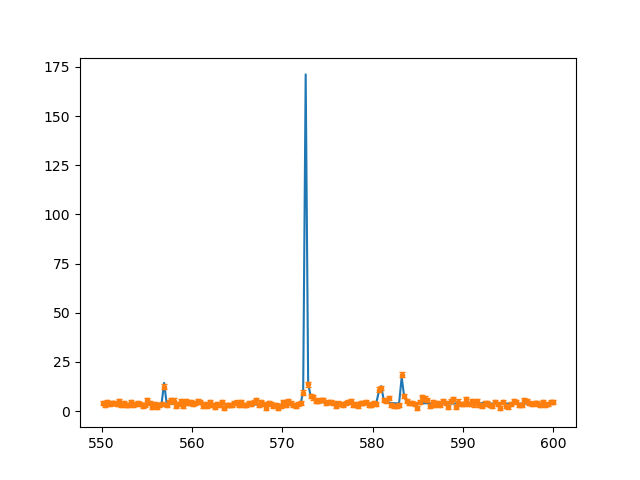

In [14]:

ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,   'unc'   :   0},
                         'n':  {'val':0.067166,     'unc'   :0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


theo_resladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
# resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
# resonance_ladder = pd.DataFrame({'E':[575], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[5000], 'Gg':[75]})
true, _, _ = SLBW(exp.energy_domain, Ta_pair, theo_resladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

exp.run(df_true)

# from ATARI.theory.experimental import trans_2_xs

threshold_0T = 1e-2
exp_par = ExperimentalParameters(0.067166, 0, threshold_0T)
theo_par = TheoreticalParameters(Ta_pair, theo_resladder, 'theo')
# est_par = TheoreticalParameters(Ta_pair, theo_resladder)

pwfine = pd.DataFrame({'E':fine_egrid(exp.trans.E,100)})
pw = PointwiseContainer(exp.trans, pwfine)
pw.add_experimental(exp.trans, exp.CovT, exp_par)
pw.add_model(theo_par, exp_par )


dc = DataContainer(pw, exp_par, theo_par,{})

figure()
# plot(pw.fine.E, pw.fine.theo_xs)
plot(dc.pw.exp.E, dc.pw.exp.theo_xs)
errorbar(dc.pw.exp.E, dc.pw.exp.exp_xs, yerr=dc.pw.exp.exp_xs_unc, fmt='.', capsize=2)
# plot(dc.pw.exp.E, dc.pw.exp.exp_trans, '.')
# ylim([-max_xs*.1, max_xs*1.25])


In [15]:
filepath = "/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/lasso/Ta181_500samples_E75_125/sample_0"

cov = pd.read_csv(os.path.join(filepath, 'cov.csv'), index_col=0)
true_par = pd.read_csv(os.path.join(filepath, 'ladder.csv'), index_col=0)
pw_exp = pd.read_csv(os.path.join(filepath, 'transm.csv'), index_col=0)

In [16]:
pw_exp

,index,E,theo_trans,exp_trans,theo_cs,exp_cs,exp_trans_unc,case_id
0,0,125.000000,0.777793,0.781444,3.741392,3.671681,0.036697,0
1,1,124.887561,0.777587,0.772140,3.745344,3.849999,0.036236,0
2,2,124.775274,0.777364,0.858150,3.749619,2.277585,0.041008,0
3,3,124.663138,0.777122,0.755021,3.754258,4.183800,0.035187,0
4,4,124.551153,0.776858,0.787861,3.759309,3.549922,0.037410,0
...,...,...,...,...,...,...,...,...
642,642,75.239510,0.785338,0.847954,3.597674,2.455537,0.042828,0
643,643,75.186995,0.785333,0.793240,3.597762,3.448606,0.040805,0
644,644,75.134535,0.785329,0.829027,3.597849,2.791626,0.041243,0
645,645,75.082129,0.785324,0.794453,3.597936,3.425855,0.040473,0


## Full feature bank and unconstrained solve

In [17]:
import classes as cls

In [18]:
average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5
Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e0, 1e0)
# Gtot_features = np.round(np.array(theo_resladder.Gt),1)*1e-3
# Elam_features = np.round(np.array(theo_resladder.E),1)
# Elam_features = Elam_features[0:int(len(Elam_features)/2)]
# Gtot_features = Gtot_features[::2]


w_threshold = 1e-10
prob = cls.ProblemHandler(w_threshold)

fb0 = prob.get_FeatureBank(dc, Elam_features, Gtot_features)
inp0 = prob.get_MatrixInputs(dc, fb0)

sol_lp0 = cls.Solvers.solve_linear_program(inp0)
print(fb0.nfeatures)
print(np.count_nonzero(sol_lp0>0))
Gtot_features

1938
910


array([0.0575304, 0.0585304, 0.0595304, 0.0605304, 0.0615304, 0.0625304,
       0.0635304, 0.0645304, 0.0655304, 0.0665304, 0.0675304, 0.0685304,
       0.0695304, 0.0705304, 0.0715304, 0.0725304, 0.0735304, 0.0745304,
       0.0755304, 0.0765304, 0.0775304, 0.0785304, 0.0795304, 0.0805304,
       0.0815304, 0.0825304, 0.0835304, 0.0845304, 0.0855304, 0.0865304,
       0.0875304, 0.0885304, 0.0895304, 0.0905304, 0.0915304, 0.0925304,
       0.0935304, 0.0945304])

In [19]:
### Unit test for feature bank construction

# fb0 = prob.get_FeatureBank(dc, [575], [100e-3])
# # inp0 = prob.get_MatrixInputs(dc, fb0)
# fb0.solution_ws = np.array([50e-6])
# test_par = TheoreticalParameters(Ta_pair, pd.DataFrame({'E':575, 'Gt':100, 'Gnx':50, 'Gg':50, 'J':3.0,'chs':1,'lwave':0.0, 'J_ID':None}, index=[0]))
# test,_,_ = SLBW(dc.pw.exp.E, Ta_pair, test_par.resonance_ladder)

# figure()
# plot(dc.pw.exp.E, fb0.model-test)
# # plot(dc.pw.exp.E, test)


In [20]:
test = np.argwhere(sol_lp0>0).flatten()

In [21]:
inputs = inp0
c = np.ones(fb0.nfeatures)
lp_minw_unred = linprog(c, A_ub=inputs.G, b_ub=inputs.h, bounds=np.array([inputs.lb, inputs.ub]).T)
required = np.argwhere(lp_minw_unred.x>0).flatten()

# for i in range(len(required)):
#     print(required[i] in test)

sol_lp0[required] = 1
print(np.count_nonzero(sol_lp0>0))

910


     pcost       dcost       gap    pres   dres
 0:  2.0258e+02  1.8305e+03  2e+05  3e+01  1e-02
 1:  2.7511e+03  3.1358e+03  3e+04  3e+00  1e-03
 2:  2.9981e+03  3.6732e+03  2e+04  2e+00  9e-04
 3:  3.7441e+03  5.5271e+03  2e+04  1e+00  6e-04
 4:  4.8550e+03  6.4861e+03  1e+04  7e-01  3e-04
 5:  5.1768e+03  7.1879e+03  1e+04  6e-01  3e-04
 6:  5.5607e+03  9.0327e+03  1e+04  5e-01  2e-04
 7:  8.6113e+03  1.3354e+04  8e+03  3e-01  1e-04
 8:  9.7570e+03  1.4412e+04  7e+03  2e-01  1e-04
 9:  1.0977e+04  1.5543e+04  7e+03  2e-01  8e-05
10:  1.2334e+04  1.6376e+04  6e+03  1e-01  6e-05
11:  1.3726e+04  1.6955e+04  5e+03  1e-01  5e-05
12:  1.4489e+04  1.7246e+04  5e+03  8e-02  4e-05
13:  1.5131e+04  1.7487e+04  5e+03  7e-02  3e-05
14:  1.5567e+04  1.7707e+04  5e+03  6e-02  3e-05
15:  1.6031e+04  1.7894e+04  4e+03  5e-02  2e-05
16:  1.6287e+04  1.8054e+04  4e+03  5e-02  2e-05
17:  1.6531e+04  1.8205e+04  4e+03  4e-02  2e-05
18:  1.6920e+04  1.8370e+04  4e+03  3e-02  2e-05
19:  1.7353e+04  1.87

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


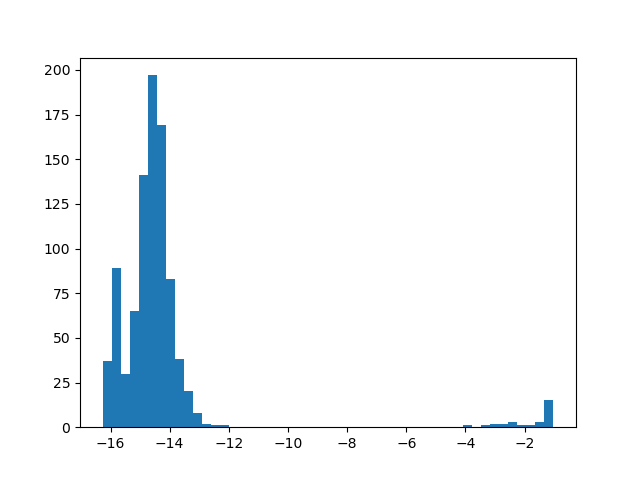

In [22]:
qpopt = cls.QPopt(verbose=True,
                abstol = 1e-12,
                reltol = 1e-12,
                feastol=1e-7,
                maxiters=200)

# reduce from LP
fb1, sol_lp0_ereduced = prob.reduce_FeatureBank(fb0, sol_lp0)
inp1 = prob.get_MatrixInputs(dc, fb1)
# fb1 = fb0
# inp1 = inp0

# fb1.solution_ws = cls.Solvers.solve_quadratic_program(inp1, qpopt)
# print(fb1.nfeatures)
inputs = inp1
sol_w = solve_qp(inputs.P, inputs.q, G=inputs.G, h=inputs.h, A=None, b=None, lb=inputs.lb, ub=inputs.ub, 
                                                                                                    solver=qpopt.solver,
                                                                                                    verbose=qpopt.verbose,
                                                                                                    abstol=qpopt.abstol,
                                                                                                    reltol=qpopt.reltol,
                                                                                                    feastol=qpopt.feastol,
                                                                                                    maxiters=qpopt.maxiters
                                                                                                    )
fb1.solution_ws = sol_w
print(fb1.get_parameter_solution())
# print(np.count_nonzero(sol_w>1e-10))
figure()
bins = hist(np.log10(sol_w), bins=50)

In [32]:
np.array([np.quantile(fb1.solution_ws, q) for q in [0.95, 0.96, 0.97,0.98, 0.99]])

array([4.74423899e-14, 8.82281296e-14, 3.59555495e-04, 1.61000449e-02,
       5.83819562e-02])

### Now perform bisection method to find weight constraints for integer number of resonances

In [62]:
### Find minimum solvable weight after reduction

c = np.ones_like(unconstrained_w)
lp_minw = linprog(c, A_ub=G, b_ub=h, bounds=np.array([lb, ub]).T)
min_wcon = np.sum(lp_minw.x)

print(min_wcon)

# figure()
# errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='k', color='k', capsize=1, ms=2)
# # plot(dc.pw_exp.E, Resonance_Matrix@lp_minw.x+potential_scattering.flatten(), lw=2, color='purple')
# plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten(), color='blue')
# ylim([-5, max_xs*1.5])

0.0


In [63]:
index_0T

array([], dtype=int64)

In [64]:
def solve_qp_w_constraint(P, q, G, h, lb, ub, w_constraint, w_threshold=1e-10, verbose_bool = False):
    G_wc = np.vstack([G,np.ones(len(P))])
    h_wc = np.append(h, w_constraint)
    qp_res_c = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt",
                                                        verbose=verbose_bool,
                                                        abstol=1e-7,
                                                        reltol=1e-7,
                                                        feastol= 1e-7,
                                                        maxiters = 200) 
    if qp_res_c is None:
        _ =0 
    return qp_res_c, np.count_nonzero(qp_res_c>w_threshold)


def solve_wcons(ws, maxres, numres_wcon, solution_ws):
    for w in ws:
        try:
            constrained_ws, numres = solve_qp_w_constraint(P, q, G, h, lb, ub, w, w_threshold, verbose_bool=False)
            print(f'{numres} resonance solution found at w={w}')
            solution = True
        except:
            print(f'Failed at weight: {w}')
            solution = False
            if w > numres_wcon[1, 0]:
                numres_wcon[1, 0] =  w

        if solution:
            if numres >= maxres:
                numres_wcon = np.concatenate((numres_wcon,np.array([[numres], [w]])), axis=1)
            else:
                numres_wcon[1, numres] = w
                solution_ws[:, numres] = constrained_ws 
    return numres_wcon, solution_ws


def bisect_and_get_new_wcons(numres_wcon):

    found = numres_wcon[:, numres_wcon[1,:]!=0]
    notfound = numres_wcon[:, numres_wcon[1,:]==0]

    est_indices = np.searchsorted(found[0,:],notfound[0,:])
    ub_search_interval, ub_search_interval_counts = np.unique(found[:,est_indices], return_counts=True, axis=1)

    new_w = np.array([])
    for iub, vub in enumerate(ub_search_interval[1,:]):
        if iub == 0:
            lower = numres_wcon[1,0]
        else:
            lower = ub_search_interval[1, iub-1]
        upper = ub_search_interval[1, iub]
        new_w = np.append(new_w, np.linspace(lower, upper, ub_search_interval_counts[iub]+1, endpoint=False)[1::])

    return new_w


w_threshold = 1e-10
max_wcon = np.sum(unconstrained_w)
max_numres = np.count_nonzero(unconstrained_w>w_threshold)
min_wcon_solw, min_numres = solve_qp_w_constraint(P, q, G, h, lb, ub, min_wcon, w_threshold, verbose_bool=True)


     pcost       dcost       gap    pres   dres
 0: -3.9638e+02 -2.4143e+03  1e+04  3e+00  1e-03
 1: -3.9609e+02 -1.3568e+03  2e+03  2e-01  1e-04
 2: -3.9403e+02 -7.4961e+02  5e+02  5e-02  2e-05
 3: -3.9193e+02 -5.7038e+02  3e+02  2e-02  9e-06
 4: -3.9090e+02 -5.0293e+02  2e+02  9e-03  5e-06
 5: -3.8737e+02 -4.6547e+02  1e+02  5e-03  3e-06
 6: -3.8547e+02 -4.2295e+02  6e+01  2e-03  1e-06
 7: -3.8466e+02 -4.1675e+02  6e+01  2e-03  8e-07
 8: -3.8257e+02 -4.0201e+02  4e+01  1e-03  5e-07
 9: -3.8101e+02 -3.9199e+02  3e+01  7e-04  4e-07
10: -3.8004e+02 -3.8710e+02  3e+01  6e-04  3e-07
11: -3.7894e+02 -3.8183e+02  3e+01  5e-04  3e-07
12: -3.7802e+02 -3.7634e+02  3e+01  5e-04  2e-07
13: -3.7577e+02 -3.6128e+02  3e+01  4e-04  2e-07
14: -3.7396e+02 -3.5251e+02  3e+01  4e-04  2e-07
15: -3.6774e+02 -3.2984e+02  4e+01  3e-04  2e-07
16: -3.6107e+02 -3.1396e+02  5e+01  3e-04  1e-07
17: -3.5022e+02 -2.9569e+02  5e+01  2e-04  1e-07
18: -3.3965e+02 -2.8336e+02  5e+01  2e-04  1e-07
19: -3.2849e+02 -2.72

In [21]:
def bisect(x0,x1):
    # return x0 + (x1-x0)/2
    return (x0+x1)/2

def bisect_and_solve(current_target_ires, minval, maxval, target_numres, wcon, sol_ws, save_all, searching=True, termination_threshold=1e-3):

    icurrent_target_ires = current_target_ires-min(target_numres)
    
    if current_target_ires == 11:
        _=0
    while searching:

        # check termination criteria
        if abs((minval-maxval)/maxval) < termination_threshold:
            searching = False
        elif wcon[icurrent_target_ires] > 0:
            searching = False

        # bisect, solve, and save result
        new_w = bisect(minval, maxval)
        con_sol_ws, numres_sol = solve_qp_w_constraint(P, q, G, h, lb, ub, new_w, w_threshold, verbose_bool=False)
        ires_sol = numres_sol-min(target_numres)
        save_all.append((new_w, numres_sol))

        if numres_sol == current_target_ires:
            #record if current target
            if wcon[ires_sol] < new_w:
                wcon[ires_sol] = new_w
                sol_ws[:,ires_sol] = con_sol_ws

        elif numres_sol > current_target_ires:
            # record other if in target numres
            if numres_sol in target_numres:
                if wcon[ires_sol] < new_w:
                    wcon[ires_sol] = new_w
                    sol_ws[:,ires_sol] = con_sol_ws
            # bisect again to find current target
            wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, minval, new_w, target_numres, wcon, sol_ws, save_all, searching=searching)

        elif numres_sol < current_target_ires:
            # record other if in target numres
            if numres_sol in target_numres:
                if wcon[ires_sol] < new_w:
                    wcon[ires_sol] = new_w
                    sol_ws[:,ires_sol] = con_sol_ws
            # bisect again to find current target
            wcon, sol_ws, save_all, searching = bisect_and_solve(current_target_ires, new_w, maxval, target_numres, wcon, sol_ws, save_all, searching=searching)

    return wcon, sol_ws, save_all, searching

### Improvements

still fails sometimes when running a huge feature matrix??

In [22]:
def get_bounding_wcons(ires_target, save_all):
    temp = np.array(save_all)
    temp = temp[temp[:,0].argsort()]
    index = np.searchsorted(temp[:,1], ires_target, side='right')
    return temp[index-1,0], temp[index,0]

def get_target_numres_array(target_maxres, max_numres):
    return np.arange(min_numres, np.min([target_maxres,max_numres])+1, 1)

def get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw, target_wcon=None, sol_ws = None):
    if target_wcon is None and sol_ws is None:
        target_wcon = np.zeros(len(target_numres))
        if min_wcon == 0:
            min_wcon = 1e-10
        target_wcon[0] = min_wcon
        sol_ws = np.zeros((len(min_wcon_solw), len(target_numres)))
        sol_ws[:, 0] = min_wcon_solw
    elif target_wcon is None or sol_ws is None:
        raise ValueError("Either target_wcon or sol_ws is None while the other is populated, check input.")
    else:
        elements_to_add = len(target_numres)-len(target_wcon)
        assert elements_to_add >= 0, "target_numres is shorter than target_wcon"
        target_wcon = np.append(target_wcon, [0]*elements_to_add)
        sol_ws = np.append(sol_ws, np.zeros((np.shape(sol_ws)[0], elements_to_add)), axis=1)
    return target_wcon, sol_ws



In [ ]:
max_numres

118

In [ ]:
target_numres = get_target_numres_array(50, max_numres)
target_wcon, target_sol_ws = get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw, target_wcon=None, sol_ws=None)
save_all = [(min_wcon, min_numres), (max_wcon, max_numres)]

print(target_numres)
print(target_wcon)

# current_target_ires = max(target_numres)
# while np.any(target_wcon==0):
for current_target_ires in target_numres[::-1]:
    print(f'Found: {target_numres[target_wcon!=0]}')
    print(f'Current target: {current_target_ires}')
    minwcon, maxwcon = get_bounding_wcons(current_target_ires, save_all) 
    target_wcon, target_sol_ws, save_all, _ = bisect_and_solve(current_target_ires, 
                                                            minwcon, maxwcon,
                                                            target_numres, target_wcon, target_sol_ws, save_all)
    # current_target_ires -= 1

print(target_numres)
print(target_wcon)

[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
[0.04590982 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
Found: [9]
Current target: 50
Found: [ 9 42 45 50]
Current target: 49
Found: [ 9 42 45 46 47 48 50]
Current target: 48
Found: [ 9 42 45 46 47 48 50]
Current target: 47
Found: [ 9 42 45 46 47 48 50]
Current target: 46
Found: [ 9 42 45 46 47 48 50]
Current target: 45
Found: [ 9 42 45 46 47 48 50]
Current target: 44
Found: [ 9 40 42 43 44 45 46 47 48 50]
Current target: 43
Found: [ 9 40 42 43 44 45 46 47 48 50]
Current target: 42
Found: [ 9 40 42 4

In [ ]:
print(target_numres)
print(target_wcon)

[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50]
[0.04590982 0.04604626 0.04608036 0.04611447 0.04618269 0.04645556
 0.04664316 0.04665169 0.04672843 0.04713773 0.04734239 0.0474106
 0.04761526 0.04771758 0.04775169 0.04781991 0.04890712 0.
 0.04809278 0.         0.04932922 0.04933775 0.04938891 0.04994881
 0.         0.         0.         0.         0.         0.
 0.04945713 0.05136721 0.         0.05198117 0.05211761 0.05213466
 0.05252691 0.05272304 0.05262924 0.05266335 0.         0.05355017]


In [ ]:
### Resolve with more resonance targets if desired

# target_numres = get_target_numres_array(75, max_numres)
# target_wcon, target_sol_ws = get_target_wcon_solw_arrays(target_numres, min_wcon, min_wcon_solw, target_wcon=target_wcon, sol_ws=target_sol_ws)

# current_target_ires = max(target_numres)
# while np.any(target_wcon==0):
#     print(f'Found: {target_numres[target_wcon!=0]}')
#     print(f'Current target: {current_target_ires}')
#     minwcon, maxwcon = get_bounding_wcons(current_target_ires, save_all) 
#     target_wcon, target_sol_ws, save_all, _ = bisect_and_solve(current_target_ires, 
#                                                             minwcon, maxwcon,
#                                                             target_numres, target_wcon, target_sol_ws, save_all)
#     current_target_ires -= 1

# print(target_numres)
# print(target_wcon)

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


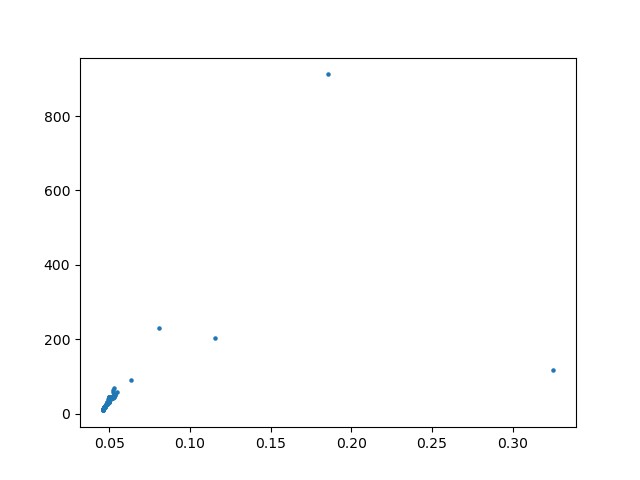

In [ ]:
figure()
scatter(np.array(save_all)[:,0],np.array(save_all)[:,1], s=5)

In [ ]:
# solve_qp_w_constraint(P, q, G, h, lb, ub,  .0831, w_threshold, verbose_bool=False)

## Solve unconstrained problem with reduced feature matrix

In [ ]:
from scipy.integrate import trapezoid
from ATARI.utils.misc import fine_egrid
from ATARI.utils.atario import fill_resonance_ladder
from ATARI.utils.stats import chi2_val

def calculate_integral_FoMs(weights, Elam_features, Gtot_features, threshold, datacon):
    est_resonance_ladder = fn.get_resonance_ladder_from_feature_bank(weights, Elam_features, Gtot_features, threshold)
    est_resonance_ladder = fill_resonance_ladder(est_resonance_ladder, Ta_pair, J=3.0, chs=1.0, lwave=0.0, J_ID=1.0)

    xs = Resonance_Matrix@weights+potential_scattering.flatten()
    trans = np.exp(-exp.redpar.val.n*xs)

    fineE = fine_egrid(datacon.pw_exp.E, 1e2)
    est_xs_tot, _, _ = SLBW(fineE, datacon.particle_pair, est_resonance_ladder)
    theo_xs_tot, _, _ = SLBW(fineE, datacon.particle_pair, datacon.theo_resonance_ladder)
    MSE = trapezoid((est_xs_tot-theo_xs_tot)**2, fineE)
    bias = est_xs_tot-theo_xs_tot

    return MSE, bias



def get_reduced_feature_matrix(full_feature_matrix, solution_ws, w_threshold, Elam_features, Gtot_features):
    # reduce feature bank
    index_w_surviving = np.argwhere(solution_ws>w_threshold).flatten()
    reduced_feature_matrix = full_feature_matrix[:, index_w_surviving]
    # map to surviving features 
    Efeature_index, Gfeature_index = divmod(index_w_surviving, len(Gtot_features))
    Elam_features_reduced = Elam_features[Efeature_index]
    Gtot_features_reduced = Gtot_features[Gfeature_index]
    reduced_feature_pairs = np.array([Elam_features_reduced, Gtot_features_reduced]).T
    return reduced_feature_matrix, reduced_feature_pairs


def get_resonance_ladder_from_feature_pairs(weights, feature_pairs):
    Elam = feature_pairs[:,0]
    Gt = feature_pairs[:,1]*1e3
    Gnx = Gt*weights
    Gg = Gt-Gnx
    resonances = np.array([Elam, Gt, Gnx, Gg, weights])
    resonance_ladder = pd.DataFrame(resonances.T, columns=['E', 'Gt', 'Gnx', 'Gg', 'w'])
    return resonance_ladder


In [ ]:
def remove_nan_values(full_xs, full_cov, full_pscat, full_feature_matrix):
    index_0T = np.argwhere(np.isnan(full_xs)).flatten()
    index_finiteT = np.argwhere(np.isfinite(full_xs)).flatten()

    cov = full_cov.copy()[index_finiteT, :]
    cov = cov[:, index_finiteT]

    xs = full_xs[index_finiteT]
    pscat = full_pscat[index_finiteT]

    feature_matrix = full_feature_matrix[index_finiteT, :]

    return xs, cov, pscat, feature_matrix, index_0T

In [ ]:

dc = DataContainer()
dc.add_theoretical(Ta_pair, resonance_ladder)
threshold_0T = 1e-2
dc.add_experimental(exp, threshold=threshold_0T)

print(target_numres[target_wcon!=0])

[ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 27 29 30 31 32 39 40
 42 43 44 45 46 47 48 50]


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
def solve_unconstrained_reduced_solution(constrained_unreduced_solution, feature_matrix, feature_pairs, w_threshold, exp_E, exp_xs, pscat, cov, max_xs, particle_pair):

    reduced_feature_matrix, reduced_feature_pairs, reduced_constrainted_solw = fn.get_reduced_features(feature_matrix, 
                                                                                  constrained_unreduced_solution, 
                                                                                  w_threshold, feature_pairs)

    P_reduced, q_reduced, G_reduced, h_reduced, lb_reduced, ub_reduced, index_0T_reduced = fn.get_qp_inputs(exp_E, exp_xs, cov, pscat, max_xs, 
                                                                                                            reduced_feature_matrix, reduced_feature_pairs, particle_pair)
    
    unconstrained_solw_reduced = solve_qp(P_reduced, q_reduced, G=G_reduced, h=h_reduced, A=None, b=None, lb=lb_reduced, ub=ub_reduced, 
                                                                                                    solver="cvxopt",
                                                                                                    verbose=True,
                                                                                                    abstol=1e-12,
                                                                                                    reltol=1e-12,
                                                                                                    feastol= 1e-8,
                                                                                                    maxiters = 100)
    
    return unconstrained_solw_reduced, reduced_feature_pairs, reduced_feature_matrix, reduced_constrainted_solw


inumres = 14

# constrained
constrained_solution = target_sol_ws[:, inumres]
# est_resonance_ladder = fn.get_resonance_ladder_from_feature_bank(constrained_solution, Elam_features, Gtot_features, 1e-10)

# theo 
# theo_xs_tot, _, _ = SLBW(fineE, dc.particle_pair, dc.theo_resonance_ladder)

# unconstrained, reduced
unconstrained_solw_reduced, reduced_feature_pairs, reduced_feature_matrix, reduced_constrainted_solw = solve_unconstrained_reduced_solution(constrained_solution, 
                                                                                                    Resonance_Matrix, 
                                                                                                    feature_pairs, w_threshold,
                                                                                                    np.array(dc.pw_exp.E),np.array(dc.pw_exp.exp_xs), 
                                                                                                    potential_scattering.flatten(), 
                                                                                                    np.array(dc.CovXS), max_xs, Ta_pair)

constrained_resonance_ladder = get_resonance_ladder_from_feature_pairs(reduced_constrainted_solw, reduced_feature_pairs)
dc.add_estimate(constrained_resonance_ladder, est_name=f'est_{inumres}_con')

reduced_resonance_ladder_reduced = get_resonance_ladder_from_feature_pairs(unconstrained_solw_reduced, reduced_feature_pairs)
dc.add_estimate(reduced_resonance_ladder_reduced, est_name=f'est_{inumres}')

exp_xs, exp_cov, _, _, index_0T = remove_nan_values( np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), Resonance_Matrix) 


xs = np.array(dc.pw_exp[f'est_{inumres}_con_xs'])
xs_reduced = np.array(dc.pw_exp[f'est_{inumres}_xs'])

print(chi2_val( np.delete(xs,index_0T) , exp_xs, exp_cov).flatten())
print(chi2_val( np.delete(xs_reduced,index_0T), exp_xs, exp_cov).flatten())

     pcost       dcost       gap    pres   dres
 0: -1.1704e+02 -1.1011e+02  5e+02  6e-01  8e-01
 1: -1.2551e+02 -1.9784e+02  2e+02  2e-01  3e-01
 2: -1.4458e+02 -2.0025e+02  8e+01  4e-02  5e-02
 3: -1.4757e+02 -1.7438e+02  3e+01  1e-02  2e-02
 4: -1.5061e+02 -1.6433e+02  2e+01  6e-03  9e-03
 5: -1.5656e+02 -1.7072e+02  2e+01  3e-03  4e-03
 6: -1.5677e+02 -1.5884e+02  2e+00  4e-04  6e-04
 7: -1.5651e+02 -1.5744e+02  2e+00  3e-04  4e-04
 8: -1.5617e+02 -1.5693e+02  1e+00  2e-04  2e-04
 9: -1.5597e+02 -1.5662e+02  1e+00  9e-05  1e-04
10: -1.5580e+02 -1.5615e+02  5e-01  2e-05  3e-05
11: -1.5574e+02 -1.5601e+02  3e-01  9e-06  1e-05
12: -1.5573e+02 -1.5591e+02  2e-01  5e-06  7e-06
13: -1.5569e+02 -1.5582e+02  1e-01  1e-15  1e-16
14: -1.5571e+02 -1.5573e+02  2e-02  1e-15  1e-16
15: -1.5571e+02 -1.5572e+02  2e-03  2e-15  1e-16
16: -1.5571e+02 -1.5571e+02  4e-05  1e-15  1e-16
17: -1.5571e+02 -1.5571e+02  4e-07  2e-15  1e-16
18: -1.5571e+02 -1.5571e+02  4e-09  2e-15  1e-16
19: -1.5571e+02 -1.55

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[374.20917719]
[218.47862717]


In [ ]:
index_0T

array([ 92, 139, 158, 159, 160])

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


(-5.0, 7.6752836433134854)

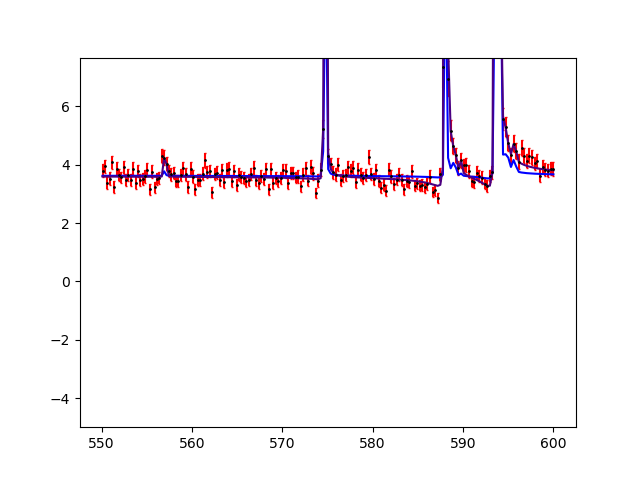

In [ ]:
figure()

errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
plot(dc.pw_exp.E, Resonance_Matrix@constrained_solution+potential_scattering.flatten(), color='blue')
plot(dc.pw_exp.E, reduced_feature_matrix@unconstrained_solw_reduced+potential_scattering.flatten(), color='indigo')


# plot(dc.pw_exp.E, xs, color='blue')
# plot(dc.pw_exp.E, xs_reduced, color='indigo')

# plot(dc.pw_exp.E, test, 'g')
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs, 'g')
# plot(dc.pw_fine.E, dc.pw_fine[f'est_{12}_xs'], 'b', lw=3) #-dc.pw_fine[f'est_{15}_xs'])
# plot(dc.pw_fine.E, dc.pw_fine[f'est_{15}_xs'],'r')
# plot(dc.pw_exp.E, reduced_feature_matrix@unconstrained_w_reduced, 'b')
# plot(dc.pw_exp.E, reduced_feature_matrix[:,10], 'r')

# scatter(np.array(dc.pw_exp.E)[index_0T], np.ones(len(index_0T))*max_xs)
ylim([-5, max_xs])

In [ ]:
chi2 = []
chi2_trans = []
MSE = []
mean_bias = []
std_bias = []

chi2_trans_con = []
chi2_con = []
MSE_con = []
mean_bias_con = []
std_bias_con = []

# get experimental and true solutions
exp_xs, exp_cov, _, _, index_0T = remove_nan_values( np.array(dc.pw_exp.exp_xs), np.array(dc.CovXS), potential_scattering.flatten(), Resonance_Matrix) 

for numres in target_numres[target_wcon!=0]:
    
    inumres = numres-min(target_numres)

    # constrained unreduced
    constrained_solution = target_sol_ws[:, inumres]
    # est_resonance_ladder = fn.get_resonance_ladder_from_feature_bank(constrained_solution, Elam_features, Gtot_features, 1e-10)

    # unconstrained reduced
    unconstrained_solw_reduced, reduced_feature_pairs, reduced_feature_matrix, constrained_reduced_solw  = solve_unconstrained_reduced_solution(constrained_solution, 
                                                                                                    Resonance_Matrix, 
                                                                                                    feature_pairs, w_threshold,
                                                                                                    np.array(dc.pw_exp.E),np.array(dc.pw_exp.exp_xs), 
                                                                                                    potential_scattering.flatten(), 
                                                                                                    np.array(dc.CovXS), max_xs, Ta_pair)
        
    est_resonance_ladder = get_resonance_ladder_from_feature_pairs(constrained_reduced_solw, reduced_feature_pairs)
    dc.add_estimate(est_resonance_ladder, est_name=f'est_{numres}_con')

    est_resonance_ladder_reduced = get_resonance_ladder_from_feature_pairs(unconstrained_solw_reduced, reduced_feature_pairs)
    dc.add_estimate(est_resonance_ladder_reduced, est_name=f'est_{numres}')

    xs = np.array(dc.pw_exp[f'est_{numres}_con_xs'])
    xs_reduced = np.array(dc.pw_exp[f'est_{numres}_xs'])
    trans = np.array(dc.pw_exp[f'est_{numres}_con_trans'])
    trans_reduced = np.array(dc.pw_exp[f'est_{numres}_trans'])

    chi2_con.append(chi2_val( np.delete(xs,index_0T) , exp_xs, exp_cov).flatten())
    chi2.append(chi2_val( np.delete(xs_reduced,index_0T), exp_xs, exp_cov).flatten())
    chi2_trans_con.append( chi2_val( trans , dc.pw_exp.exp_trans, dc.CovT).flatten() )
    chi2_trans.append( chi2_val( trans_reduced , dc.pw_exp.exp_trans, dc.CovT).flatten() )

    MSE_con.append( trapezoid((dc.pw_fine[f'est_{numres}_con_xs']-dc.pw_fine.theo_xs)**2, dc.pw_fine.E) )
    MSE.append( trapezoid((dc.pw_fine[f'est_{numres}_xs']-dc.pw_fine.theo_xs)**2, dc.pw_fine.E) )

    bias_con = abs(dc.pw_fine[f'est_{numres}_con_xs']-dc.pw_fine.theo_xs)
    bias = abs(dc.pw_fine[f'est_{numres}_xs']-dc.pw_fine.theo_xs)
    mean_bias_con.append(np.mean(bias_con))
    std_bias_con.append(np.std(bias_con))
    mean_bias.append(np.mean(bias))
    std_bias.append(np.std(bias))


     pcost       dcost       gap    pres   dres
 0: -4.7385e+01 -2.7005e+01  3e+02  5e-01  2e+01
 1: -7.3953e+01 -1.4660e+02  2e+02  2e-01  9e+00
 2: -1.0447e+02 -1.4774e+02  6e+01  6e-02  2e+00
 3: -1.1526e+02 -1.3647e+02  3e+01  2e-02  9e-01
 4: -1.2914e+02 -1.5190e+02  2e+01  5e-03  2e-01
 5: -1.3084e+02 -1.3826e+02  8e+00  2e-03  6e-02
 6: -1.3461e+02 -1.4003e+02  5e+00  6e-04  2e-02
 7: -1.3523e+02 -1.3649e+02  1e+00  1e-04  5e-03
 8: -1.3550e+02 -1.3563e+02  1e-01  6e-06  2e-04
 9: -1.3554e+02 -1.3559e+02  4e-02  2e-06  7e-05
10: -1.3555e+02 -1.3559e+02  4e-02  1e-06  5e-05
11: -1.3555e+02 -1.3558e+02  2e-02  5e-07  2e-05
12: -1.3556e+02 -1.3556e+02  1e-03  2e-08  8e-07
13: -1.3556e+02 -1.3556e+02  1e-05  2e-10  9e-09
14: -1.3556e+02 -1.3556e+02  1e-07  2e-12  9e-11
15: -1.3556e+02 -1.3556e+02  1e-09  2e-14  9e-13
16: -1.3556e+02 -1.3556e+02  1e-11  2e-15  9e-15
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -5.9608e+01 -4.0927e+01  4e+02  5e-01  3e+00
 1: -8.6146e+01 -1.6084e+02  2e+02  2e-01  1e+00
 2: -1.1694e+02 -1.5629e+02  5e+01  5e-02  3e-01
 3: -1.2639e+02 -1.4737e+02  3e+01  2e-02  1e-01
 4: -1.3954e+02 -1.6145e+02  2e+01  4e-03  2e-02
 5: -1.4138e+02 -1.4911e+02  8e+00  1e-03  8e-03
 6: -1.4512e+02 -1.5059e+02  6e+00  5e-04  3e-03
 7: -1.4573e+02 -1.4692e+02  1e+00  1e-04  6e-04
 8: -1.4599e+02 -1.4613e+02  1e-01  7e-06  4e-05
 9: -1.4604e+02 -1.4610e+02  6e-02  2e-06  9e-06
10: -1.4605e+02 -1.4607e+02  2e-02  1e-07  8e-07
11: -1.4605e+02 -1.4606e+02  1e-02  4e-08  2e-07
12: -1.4606e+02 -1.4606e+02  5e-04  2e-09  1e-08
13: -1.4606e+02 -1.4606e+02  5e-06  2e-11  1e-10
14: -1.4606e+02 -1.4606e+02  5e-08  2e-13  1e-12
15: -1.4606e+02 -1.4606e+02  5e-10  2e-15  1e-14
16: -1.4606e+02 -1.4606e+02  5e-12  2e-15  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -6.5221e+01 -4.7356e+01  4e+02  5e-01  2e+00
 1: -9.0767e+01 -1.6666e+02  2e+02  2e-01  8e-01
 2: -1.2042e+02 -1.5994e+02  6e+01  5e-02  2e-01
 3: -1.2875e+02 -1.4992e+02  3e+01  2e-02  7e-02
 4: -1.4037e+02 -1.5735e+02  2e+01  4e-03  1e-02
 5: -1.4224e+02 -1.4836e+02  6e+00  1e-03  5e-03
 6: -1.4536e+02 -1.4960e+02  4e+00  5e-04  2e-03
 7: -1.4590e+02 -1.4656e+02  7e-01  7e-05  2e-04
 8: -1.4607e+02 -1.4617e+02  1e-01  8e-06  3e-05
 9: -1.4608e+02 -1.4618e+02  1e-01  5e-06  2e-05
10: -1.4610e+02 -1.4613e+02  3e-02  1e-06  5e-06
11: -1.4611e+02 -1.4611e+02  2e-03  9e-09  3e-08
12: -1.4611e+02 -1.4611e+02  2e-05  9e-11  3e-10
13: -1.4611e+02 -1.4611e+02  2e-07  9e-13  3e-12
14: -1.4611e+02 -1.4611e+02  2e-09  9e-15  3e-14
15: -1.4611e+02 -1.4611e+02  2e-11  2e-15  3e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -7.0859e+01 -5.4156e+01  4e+02  5e-01  1e+00
 1: -9.5723e+01 -1.7277e+02  2e+02  2e-01  7e-01
 2: -1.2456e+02 -1.6499e+02  6e+01  4e-02  1e-01
 3: -1.3212e+02 -1.5350e+02  3e+01  2e-02  6e-02
 4: -1.4253e+02 -1.5731e+02  2e+01  4e-03  1e-02
 5: -1.4415e+02 -1.4932e+02  6e+00  1e-03  4e-03
 6: -1.4668e+02 -1.5014e+02  4e+00  4e-04  1e-03
 7: -1.4709e+02 -1.4743e+02  3e-01  3e-05  9e-05
 8: -1.4720e+02 -1.4727e+02  7e-02  5e-06  2e-05
 9: -1.4721e+02 -1.4727e+02  7e-02  3e-06  1e-05
10: -1.4722e+02 -1.4723e+02  1e-02  7e-07  2e-06
11: -1.4722e+02 -1.4722e+02  3e-04  6e-09  2e-08
12: -1.4722e+02 -1.4722e+02  4e-06  6e-11  2e-10
13: -1.4722e+02 -1.4722e+02  4e-08  6e-13  2e-12
14: -1.4722e+02 -1.4722e+02  4e-10  7e-15  2e-14
15: -1.4722e+02 -1.4722e+02  4e-12  2e-15  3e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -7.6802e+01 -5.9713e+01  4e+02  5e-01  1e+00
 1: -9.7499e+01 -1.6756e+02  2e+02  2e-01  6e-01
 2: -1.2523e+02 -1.6693e+02  6e+01  5e-02  1e-01
 3: -1.3265e+02 -1.5411e+02  3e+01  2e-02  5e-02
 4: -1.4304e+02 -1.5910e+02  2e+01  4e-03  1e-02
 5: -1.4461e+02 -1.5031e+02  6e+00  1e-03  3e-03
 6: -1.4724e+02 -1.5104e+02  4e+00  5e-04  1e-03
 7: -1.4768e+02 -1.4820e+02  5e-01  5e-05  1e-04
 8: -1.4781e+02 -1.4791e+02  1e-01  9e-06  2e-05
 9: -1.4782e+02 -1.4792e+02  1e-01  7e-06  2e-05
10: -1.4784e+02 -1.4788e+02  3e-02  2e-06  6e-06
11: -1.4785e+02 -1.4785e+02  4e-03  2e-08  4e-08
12: -1.4785e+02 -1.4785e+02  3e-04  1e-09  3e-09
13: -1.4785e+02 -1.4785e+02  3e-06  1e-11  3e-11
14: -1.4785e+02 -1.4785e+02  3e-08  1e-13  3e-13
15: -1.4785e+02 -1.4785e+02  3e-10  2e-15  3e-15
16: -1.4785e+02 -1.4785e+02  3e-12  1e-15  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -7.9759e+01 -6.3999e+01  4e+02  5e-01  1e+00
 1: -9.8181e+01 -1.6715e+02  2e+02  2e-01  5e-01
 2: -1.2574e+02 -1.7017e+02  6e+01  5e-02  1e-01
 3: -1.3306e+02 -1.5540e+02  3e+01  2e-02  5e-02
 4: -1.4349e+02 -1.6058e+02  2e+01  4e-03  1e-02
 5: -1.4507e+02 -1.5113e+02  7e+00  1e-03  3e-03
 6: -1.4777e+02 -1.5180e+02  4e+00  5e-04  1e-03
 7: -1.4823e+02 -1.4890e+02  7e-01  7e-05  2e-04
 8: -1.4837e+02 -1.4849e+02  1e-01  1e-05  2e-05
 9: -1.4841e+02 -1.4848e+02  7e-02  2e-06  4e-06
10: -1.4842e+02 -1.4843e+02  1e-02  4e-08  9e-08
11: -1.4842e+02 -1.4842e+02  3e-03  6e-09  1e-08
12: -1.4842e+02 -1.4842e+02  1e-03  6e-10  1e-09
13: -1.4842e+02 -1.4842e+02  2e-05  1e-11  2e-11
14: -1.4842e+02 -1.4842e+02  2e-07  1e-13  2e-13
15: -1.4842e+02 -1.4842e+02  2e-09  2e-15  2e-15
16: -1.4842e+02 -1.4842e+02  2e-11  2e-15  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -8.7248e+01 -7.1857e+01  4e+02  5e-01  1e+00
 1: -1.0459e+02 -1.7461e+02  2e+02  2e-01  5e-01
 2: -1.3069e+02 -1.7583e+02  7e+01  5e-02  1e-01
 3: -1.3645e+02 -1.5711e+02  3e+01  2e-02  4e-02
 4: -1.4454e+02 -1.5624e+02  1e+01  4e-03  8e-03
 5: -1.4645e+02 -1.5094e+02  5e+00  1e-03  3e-03
 6: -1.4845e+02 -1.5096e+02  3e+00  4e-04  7e-04
 7: -1.4873e+02 -1.4917e+02  5e-01  6e-05  1e-04
 8: -1.4881e+02 -1.4885e+02  4e-02  9e-07  2e-06
 9: -1.4882e+02 -1.4883e+02  9e-03  2e-07  4e-07
10: -1.4883e+02 -1.4883e+02  1e-03  6e-09  1e-08
11: -1.4883e+02 -1.4883e+02  3e-05  3e-11  6e-11
12: -1.4883e+02 -1.4883e+02  3e-07  3e-13  6e-13
13: -1.4883e+02 -1.4883e+02  3e-09  4e-15  6e-15
14: -1.4883e+02 -1.4883e+02  3e-11  2e-15  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -9.0633e+01 -7.6798e+01  4e+02  5e-01  1e+00
 1: -1.0803e+02 -1.7944e+02  2e+02  2e-01  5e-01
 2: -1.3416e+02 -1.8064e+02  7e+01  5e-02  1e-01
 3: -1.3996e+02 -1.6117e+02  3e+01  2e-02  3e-02
 4: -1.4806e+02 -1.6012e+02  1e+01  4e-03  7e-03
 5: -1.4992e+02 -1.5447e+02  5e+00  1e-03  3e-03
 6: -1.5191e+02 -1.5444e+02  3e+00  4e-04  7e-04
 7: -1.5218e+02 -1.5255e+02  4e-01  4e-05  8e-05
 8: -1.5226e+02 -1.5230e+02  4e-02  2e-06  4e-06
 9: -1.5227e+02 -1.5228e+02  1e-02  4e-07  7e-07
10: -1.5227e+02 -1.5227e+02  2e-03  2e-15  1e-16
11: -1.5227e+02 -1.5227e+02  7e-05  2e-15  9e-17
12: -1.5227e+02 -1.5227e+02  1e-06  2e-15  5e-17
13: -1.5227e+02 -1.5227e+02  1e-08  3e-15  5e-17
14: -1.5227e+02 -1.5227e+02  1e-10  2e-15  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -9.4260e+01 -8.1582e+01  4e+02  5e-01  9e-01
 1: -1.1113e+02 -1.8361e+02  2e+02  2e-01  4e-01
 2: -1.3667e+02 -1.8450e+02  7e+01  5e-02  9e-02
 3: -1.4199e+02 -1.6303e+02  3e+01  2e-02  3e-02
 4: -1.4933e+02 -1.6083e+02  1e+01  4e-03  6e-03
 5: -1.5087e+02 -1.5518e+02  5e+00  1e-03  2e-03
 6: -1.5257e+02 -1.5488e+02  2e+00  3e-04  6e-04
 7: -1.5280e+02 -1.5308e+02  3e-01  3e-05  5e-05
 8: -1.5285e+02 -1.5291e+02  6e-02  5e-06  9e-06
 9: -1.5287e+02 -1.5289e+02  2e-02  1e-06  2e-06
10: -1.5287e+02 -1.5287e+02  4e-03  4e-08  6e-08
11: -1.5287e+02 -1.5287e+02  8e-05  9e-10  1e-09
12: -1.5287e+02 -1.5287e+02  8e-07  9e-12  1e-11
13: -1.5287e+02 -1.5287e+02  8e-09  9e-14  1e-13
14: -1.5287e+02 -1.5287e+02  8e-11  2e-15  1e-15
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -9.6264e+01 -8.4692e+01  4e+02  5e-01  9e-01
 1: -1.1266e+02 -1.8623e+02  2e+02  3e-01  4e-01
 2: -1.3767e+02 -1.8679e+02  7e+01  5e-02  9e-02
 3: -1.4258e+02 -1.6337e+02  3e+01  2e-02  3e-02
 4: -1.4942e+02 -1.6054e+02  1e+01  4e-03  6e-03
 5: -1.5094e+02 -1.5530e+02  5e+00  1e-03  2e-03
 6: -1.5260e+02 -1.5487e+02  2e+00  3e-04  5e-04
 7: -1.5282e+02 -1.5309e+02  3e-01  3e-05  5e-05
 8: -1.5287e+02 -1.5293e+02  6e-02  6e-06  9e-06
 9: -1.5288e+02 -1.5293e+02  5e-02  4e-06  7e-06
10: -1.5286e+02 -1.5290e+02  4e-02  1e-15  6e-16
11: -1.5287e+02 -1.5288e+02  9e-03  2e-15  1e-16
12: -1.5287e+02 -1.5287e+02  4e-04  2e-15  1e-16
13: -1.5287e+02 -1.5287e+02  4e-06  1e-15  1e-16
14: -1.5287e+02 -1.5287e+02  4e-08  1e-15  2e-16
15: -1.5287e+02 -1.5287e+02  4e-10  1e-15  1e-16
16: -1.5287e+02 -1.5287e+02  4e-12  2e-15  2e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -9.8490e+01 -8.8596e+01  4e+02  6e-01  9e-01
 1: -1.1375e+02 -1.8769e+02  2e+02  3e-01  4e-01
 2: -1.3842e+02 -1.8923e+02  8e+01  5e-02  8e-02
 3: -1.4333e+02 -1.6503e+02  3e+01  2e-02  3e-02
 4: -1.5027e+02 -1.6164e+02  1e+01  4e-03  6e-03
 5: -1.5191e+02 -1.5647e+02  5e+00  1e-03  2e-03
 6: -1.5365e+02 -1.5603e+02  3e+00  4e-04  6e-04
 7: -1.5389e+02 -1.5423e+02  4e-01  4e-05  6e-05
 8: -1.5395e+02 -1.5401e+02  7e-02  6e-06  9e-06
 9: -1.5388e+02 -1.5400e+02  1e-01  1e-15  1e-16
10: -1.5393e+02 -1.5395e+02  2e-02  1e-15  1e-16
11: -1.5394e+02 -1.5394e+02  2e-03  2e-15  1e-16
12: -1.5394e+02 -1.5394e+02  7e-05  2e-15  1e-16
13: -1.5394e+02 -1.5394e+02  7e-07  2e-15  2e-16
14: -1.5394e+02 -1.5394e+02  7e-09  2e-15  1e-16
15: -1.5394e+02 -1.5394e+02  7e-11  2e-15  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.0125e+02 -9.1630e+01  5e+02  6e-01  9e-01
 1: -1.1598e+02 -1.9047e+02  2e+02  3e-01  4e-01
 2: -1.3952e+02 -1.8849e+02  7e+01  5e-02  7e-02
 3: -1.4360e+02 -1.6704e+02  3e+01  2e-02  3e-02
 4: -1.5027e+02 -1.6093e+02  1e+01  4e-03  6e-03
 5: -1.5206e+02 -1.5647e+02  5e+00  1e-03  2e-03
 6: -1.5368e+02 -1.5587e+02  2e+00  4e-04  5e-04
 7: -1.5391e+02 -1.5416e+02  3e-01  3e-05  5e-05
 8: -1.5395e+02 -1.5401e+02  6e-02  6e-06  9e-06
 9: -1.5372e+02 -1.5410e+02  4e-01  2e-15  2e-16
10: -1.5390e+02 -1.5396e+02  6e-02  1e-15  1e-16
11: -1.5394e+02 -1.5395e+02  8e-03  1e-15  2e-16
12: -1.5394e+02 -1.5394e+02  2e-04  2e-15  2e-16
13: -1.5394e+02 -1.5394e+02  2e-06  2e-15  1e-16
14: -1.5394e+02 -1.5394e+02  2e-08  2e-15  9e-17
15: -1.5394e+02 -1.5394e+02  2e-10  1e-15  9e-17
16: -1.5394e+02 -1.5394e+02  2e-12  9e-16  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.0742e+02 -1.0074e+02  5e+02  6e-01  8e-01
 1: -1.1817e+02 -1.8885e+02  2e+02  2e-01  3e-01
 2: -1.4068e+02 -1.9873e+02  9e+01  5e-02  8e-02
 3: -1.4535e+02 -1.6938e+02  3e+01  2e-02  3e-02
 4: -1.5214e+02 -1.6503e+02  1e+01  4e-03  5e-03
 5: -1.5369e+02 -1.5871e+02  6e+00  1e-03  2e-03
 6: -1.5543e+02 -1.5792e+02  3e+00  3e-04  5e-04
 7: -1.5566e+02 -1.5597e+02  3e-01  3e-05  4e-05
 8: -1.5571e+02 -1.5578e+02  7e-02  6e-06  8e-06
 9: -1.5551e+02 -1.5586e+02  3e-01  2e-15  1e-16
10: -1.5567e+02 -1.5573e+02  6e-02  1e-15  2e-16
11: -1.5571e+02 -1.5572e+02  2e-02  9e-16  1e-16
12: -1.5571e+02 -1.5571e+02  1e-03  2e-15  9e-17
13: -1.5571e+02 -1.5571e+02  1e-05  2e-15  1e-16
14: -1.5571e+02 -1.5571e+02  1e-07  2e-15  1e-16
15: -1.5571e+02 -1.5571e+02  1e-09  1e-15  1e-16
16: -1.5571e+02 -1.5571e+02  1e-11  2e-15  1e-16
Optimal solution found.


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.1417e+02 -1.0701e+02  5e+02  6e-01  8e-01
 1: -1.2334e+02 -1.9513e+02  2e+02  2e-01  3e-01
 2: -1.4397e+02 -2.0365e+02  9e+01  5e-02  7e-02
 3: -1.4692e+02 -1.6255e+02  2e+01  1e-02  1e-02
 4: -1.5152e+02 -1.6288e+02  1e+01  6e-03  8e-03
 5: -1.5673e+02 -1.6692e+02  1e+01  2e-03  3e-03
 6: -1.5679e+02 -1.5901e+02  2e+00  4e-04  6e-04
 7: -1.5649e+02 -1.5738e+02  2e+00  4e-04  5e-04
 8: -1.5609e+02 -1.5662e+02  1e+00  2e-04  2e-04
 9: -1.5585e+02 -1.5601e+02  5e-01  5e-05  7e-05
10: -1.5575e+02 -1.5590e+02  3e-01  1e-05  2e-05
11: -1.5574e+02 -1.5582e+02  1e-01  6e-06  8e-06
12: -1.5507e+02 -1.5623e+02  1e+00  1e-15  2e-16
13: -1.5559e+02 -1.5584e+02  3e-01  1e-15  1e-16
14: -1.5568e+02 -1.5574e+02  6e-02  1e-15  1e-16
15: -1.5571e+02 -1.5572e+02  2e-02  2e-15  2e-16
16: -1.5571e+02 -1.5571e+02  9e-04  1e-15  1e-16
17: -1.5571e+02 -1.5571e+02  9e-06  2e-15  1e-16
18: -1.5571e+02 -1.5571e+02  9e-08  2e-15  1e-16
19: -1.5571e+02 -1.55

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.1704e+02 -1.1011e+02  5e+02  6e-01  8e-01
 1: -1.2551e+02 -1.9784e+02  2e+02  2e-01  3e-01
 2: -1.4458e+02 -2.0025e+02  8e+01  4e-02  5e-02
 3: -1.4757e+02 -1.7438e+02  3e+01  1e-02  2e-02
 4: -1.5061e+02 -1.6433e+02  2e+01  6e-03  9e-03
 5: -1.5656e+02 -1.7072e+02  2e+01  3e-03  4e-03
 6: -1.5677e+02 -1.5884e+02  2e+00  4e-04  6e-04
 7: -1.5651e+02 -1.5744e+02  2e+00  3e-04  4e-04
 8: -1.5617e+02 -1.5693e+02  1e+00  2e-04  2e-04
 9: -1.5597e+02 -1.5662e+02  1e+00  9e-05  1e-04
10: -1.5580e+02 -1.5615e+02  5e-01  2e-05  3e-05
11: -1.5574e+02 -1.5601e+02  3e-01  9e-06  1e-05
12: -1.5573e+02 -1.5591e+02  2e-01  5e-06  7e-06
13: -1.5569e+02 -1.5582e+02  1e-01  1e-15  1e-16
14: -1.5571e+02 -1.5573e+02  2e-02  1e-15  1e-16
15: -1.5571e+02 -1.5572e+02  2e-03  2e-15  1e-16
16: -1.5571e+02 -1.5571e+02  4e-05  1e-15  1e-16
17: -1.5571e+02 -1.5571e+02  4e-07  2e-15  1e-16
18: -1.5571e+02 -1.5571e+02  4e-09  2e-15  1e-16
19: -1.5571e+02 -1.55

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.2220e+02 -1.1637e+02  5e+02  6e-01  8e-01
 1: -1.3024e+02 -2.0338e+02  2e+02  2e-01  3e-01
 2: -1.4856e+02 -2.0495e+02  8e+01  4e-02  5e-02
 3: -1.5120e+02 -1.7760e+02  3e+01  1e-02  2e-02
 4: -1.5350e+02 -1.6571e+02  2e+01  6e-03  7e-03
 5: -1.5806e+02 -1.7011e+02  1e+01  3e-03  3e-03
 6: -1.5822e+02 -1.5995e+02  2e+00  4e-04  5e-04
 7: -1.5801e+02 -1.5889e+02  2e+00  3e-04  4e-04
 8: -1.5779e+02 -1.5828e+02  9e-01  1e-04  1e-04
 9: -1.5766e+02 -1.5790e+02  4e-01  4e-05  5e-05
10: -1.5761e+02 -1.5779e+02  2e-01  2e-05  2e-05
11: -1.5760e+02 -1.5763e+02  5e-02  3e-06  3e-06
12: -1.5754e+02 -1.5766e+02  1e-01  5e-08  7e-08
13: -1.5758e+02 -1.5761e+02  3e-02  9e-09  1e-08
14: -1.5760e+02 -1.5760e+02  3e-03  2e-15  1e-16
15: -1.5760e+02 -1.5760e+02  1e-04  1e-15  1e-16
16: -1.5760e+02 -1.5760e+02  1e-06  2e-15  1e-16
17: -1.5760e+02 -1.5760e+02  1e-08  1e-15  9e-17
18: -1.5760e+02 -1.5760e+02  1e-10  2e-15  1e-16
Optimal solution foun

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.2168e+02 -1.1866e+02  5e+02  6e-01  8e-01
 1: -1.3042e+02 -2.0562e+02  2e+02  2e-01  3e-01
 2: -1.5035e+02 -2.1189e+02  9e+01  5e-02  6e-02
 3: -1.5281e+02 -1.6886e+02  2e+01  9e-03  1e-02
 4: -1.5627e+02 -1.6699e+02  1e+01  5e-03  7e-03
 5: -1.6039e+02 -1.6975e+02  1e+01  2e-03  2e-03
 6: -1.6042e+02 -1.6249e+02  2e+00  4e-04  5e-04
 7: -1.6017e+02 -1.6119e+02  2e+00  3e-04  4e-04
 8: -1.5991e+02 -1.6033e+02  1e+00  1e-04  1e-04
 9: -1.5979e+02 -1.6006e+02  5e-01  4e-05  4e-05
10: -1.5976e+02 -1.5981e+02  7e-02  4e-06  5e-06
11: -1.5976e+02 -1.5979e+02  4e-02  2e-06  3e-06
12: -1.5974e+02 -1.5979e+02  6e-02  2e-15  1e-16
13: -1.5975e+02 -1.5976e+02  1e-02  2e-15  1e-16
14: -1.5976e+02 -1.5976e+02  6e-04  2e-15  1e-16
15: -1.5976e+02 -1.5976e+02  1e-05  2e-15  2e-16
16: -1.5976e+02 -1.5976e+02  2e-07  1e-15  1e-16
17: -1.5976e+02 -1.5976e+02  2e-09  2e-15  2e-16
18: -1.5976e+02 -1.5976e+02  2e-11  2e-15  2e-16
Optimal solution foun

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.2903e+02 -1.2902e+02  6e+02  6e-01  8e-01
 1: -1.3403e+02 -2.1609e+02  2e+02  2e-01  3e-01
 2: -1.4927e+02 -2.1749e+02  1e+02  4e-02  5e-02
 3: -1.5221e+02 -1.8127e+02  4e+01  1e-02  1e-02
 4: -1.5467e+02 -1.6901e+02  2e+01  5e-03  7e-03
 5: -1.5922e+02 -1.7234e+02  2e+01  3e-03  3e-03
 6: -1.5938e+02 -1.6141e+02  2e+00  4e-04  5e-04
 7: -1.5913e+02 -1.6025e+02  2e+00  3e-04  4e-04
 8: -1.5893e+02 -1.5941e+02  9e-01  1e-04  1e-04
 9: -1.5881e+02 -1.5909e+02  5e-01  4e-05  5e-05
10: -1.5877e+02 -1.5894e+02  2e-01  1e-05  2e-05
11: -1.5876e+02 -1.5879e+02  3e-02  2e-06  2e-06
12: -1.5876e+02 -1.5878e+02  2e-02  1e-06  1e-06
13: -1.5875e+02 -1.5877e+02  1e-02  1e-15  3e-16
14: -1.5876e+02 -1.5876e+02  7e-04  1e-15  2e-16
15: -1.5876e+02 -1.5876e+02  1e-05  2e-15  2e-16
16: -1.5876e+02 -1.5876e+02  1e-07  2e-15  2e-16
17: -1.5876e+02 -1.5876e+02  1e-09  1e-15  1e-16
18: -1.5876e+02 -1.5876e+02  1e-11  2e-15  1e-16
Optimal solution foun

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.4232e+02 -1.4500e+02  6e+02  6e-01  7e-01
 1: -1.4982e+02 -2.2798e+02  2e+02  2e-01  3e-01
 2: -1.6686e+02 -2.2828e+02  9e+01  4e-02  5e-02
 3: -1.6846e+02 -1.8930e+02  3e+01  1e-02  2e-02
 4: -1.7154e+02 -1.8264e+02  1e+01  6e-03  7e-03
 5: -1.7679e+02 -1.8863e+02  1e+01  3e-03  4e-03
 6: -1.7722e+02 -1.7880e+02  2e+00  4e-04  5e-04
 7: -1.7706e+02 -1.7778e+02  2e+00  3e-04  3e-04
 8: -1.7680e+02 -1.7764e+02  1e+00  1e-04  1e-04
 9: -1.7663e+02 -1.7722e+02  1e+00  7e-05  8e-05
10: -1.7657e+02 -1.7703e+02  8e-01  5e-05  5e-05
11: -1.7627e+02 -1.7665e+02  4e-01  3e-06  3e-06
12: -1.7625e+02 -1.7648e+02  2e-01  2e-15  1e-16
13: -1.7628e+02 -1.7632e+02  4e-02  2e-15  1e-16
14: -1.7629e+02 -1.7630e+02  9e-03  2e-15  1e-16
15: -1.7629e+02 -1.7629e+02  4e-04  2e-15  1e-16
16: -1.7629e+02 -1.7629e+02  7e-06  2e-15  1e-16
17: -1.7629e+02 -1.7629e+02  7e-08  3e-15  1e-16
18: -1.7629e+02 -1.7629e+02  7e-10  1e-15  1e-16
19: -1.7629e+02 -1.76

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.4309e+02 -1.4729e+02  6e+02  6e-01  7e-01
 1: -1.5058e+02 -2.2992e+02  2e+02  2e-01  3e-01
 2: -1.6762e+02 -2.3003e+02  9e+01  4e-02  5e-02
 3: -1.6923e+02 -1.9072e+02  3e+01  1e-02  2e-02
 4: -1.7227e+02 -1.8351e+02  1e+01  6e-03  7e-03
 5: -1.7749e+02 -1.8954e+02  1e+01  4e-03  4e-03
 6: -1.7794e+02 -1.7953e+02  2e+00  4e-04  5e-04
 7: -1.7778e+02 -1.7852e+02  2e+00  3e-04  3e-04
 8: -1.7751e+02 -1.7842e+02  1e+00  1e-04  1e-04
 9: -1.7734e+02 -1.7799e+02  1e+00  7e-05  8e-05
10: -1.7728e+02 -1.7778e+02  8e-01  5e-05  5e-05
11: -1.7697e+02 -1.7737e+02  4e-01  2e-06  3e-06
12: -1.7696e+02 -1.7717e+02  2e-01  2e-15  1e-16
13: -1.7699e+02 -1.7702e+02  3e-02  2e-15  1e-16
14: -1.7700e+02 -1.7700e+02  7e-03  1e-15  1e-16
15: -1.7700e+02 -1.7700e+02  2e-04  2e-15  9e-17
16: -1.7700e+02 -1.7700e+02  2e-06  2e-15  2e-16
17: -1.7700e+02 -1.7700e+02  2e-08  2e-15  1e-16
18: -1.7700e+02 -1.7700e+02  2e-10  2e-15  1e-16
19: -1.7700e+02 -1.77

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.4363e+02 -1.4936e+02  6e+02  7e-01  7e-01
 1: -1.5112e+02 -2.3163e+02  2e+02  2e-01  3e-01
 2: -1.6816e+02 -2.3155e+02  9e+01  4e-02  5e-02
 3: -1.6974e+02 -1.9101e+02  3e+01  1e-02  1e-02
 4: -1.7272e+02 -1.8398e+02  2e+01  6e-03  7e-03
 5: -1.7775e+02 -1.8958e+02  1e+01  4e-03  4e-03
 6: -1.7797e+02 -1.7955e+02  2e+00  4e-04  5e-04
 7: -1.7778e+02 -1.7852e+02  2e+00  3e-04  3e-04
 8: -1.7751e+02 -1.7834e+02  1e+00  1e-04  1e-04
 9: -1.7734e+02 -1.7792e+02  1e+00  7e-05  8e-05
10: -1.7727e+02 -1.7772e+02  8e-01  4e-05  5e-05
11: -1.7698e+02 -1.7730e+02  3e-01  3e-06  3e-06
12: -1.7697e+02 -1.7714e+02  2e-01  2e-15  1e-16
13: -1.7699e+02 -1.7702e+02  3e-02  2e-15  1e-16
14: -1.7700e+02 -1.7700e+02  5e-03  2e-15  1e-16
15: -1.7700e+02 -1.7700e+02  2e-04  2e-15  1e-16
16: -1.7700e+02 -1.7700e+02  2e-06  2e-15  2e-16
17: -1.7700e+02 -1.7700e+02  2e-08  2e-15  1e-16
18: -1.7700e+02 -1.7700e+02  2e-10  1e-15  2e-16
19: -1.7700e+02 -1.77

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.4838e+02 -1.5565e+02  6e+02  7e-01  7e-01
 1: -1.5591e+02 -2.3766e+02  2e+02  2e-01  3e-01
 2: -1.7304e+02 -2.3748e+02  9e+01  4e-02  5e-02
 3: -1.7487e+02 -1.9957e+02  3e+01  1e-02  2e-02
 4: -1.7776e+02 -1.8929e+02  2e+01  6e-03  7e-03
 5: -1.8303e+02 -1.9598e+02  2e+01  4e-03  4e-03
 6: -1.8354e+02 -1.8517e+02  2e+00  4e-04  5e-04
 7: -1.8341e+02 -1.8433e+02  2e+00  3e-04  4e-04
 8: -1.8309e+02 -1.8456e+02  2e+00  1e-04  1e-04
 9: -1.8289e+02 -1.8393e+02  2e+00  8e-05  9e-05
10: -1.8233e+02 -1.8323e+02  9e-01  3e-06  3e-06
11: -1.8241e+02 -1.8260e+02  2e-01  3e-07  3e-07
12: -1.8243e+02 -1.8249e+02  6e-02  8e-08  9e-08
13: -1.8244e+02 -1.8247e+02  3e-02  3e-08  4e-08
14: -1.8244e+02 -1.8245e+02  8e-03  2e-09  3e-09
15: -1.8244e+02 -1.8244e+02  1e-04  4e-11  4e-11
16: -1.8244e+02 -1.8244e+02  1e-06  4e-13  4e-13
17: -1.8244e+02 -1.8244e+02  1e-08  4e-15  4e-15
18: -1.8244e+02 -1.8244e+02  1e-10  2e-15  2e-16
Optimal solution foun

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.5867e+02 -1.7748e+02  8e+02  7e-01  7e-01
 1: -1.6170e+02 -2.5365e+02  3e+02  2e-01  2e-01
 2: -1.7281e+02 -2.5449e+02  1e+02  4e-02  4e-02
 3: -1.7477e+02 -2.0661e+02  4e+01  2e-02  2e-02
 4: -1.7774e+02 -1.9312e+02  2e+01  7e-03  6e-03
 5: -1.8296e+02 -1.9816e+02  2e+01  4e-03  4e-03
 6: -1.8350e+02 -1.8549e+02  2e+00  4e-04  4e-04
 7: -1.8330e+02 -1.8439e+02  2e+00  3e-04  3e-04
 8: -1.8305e+02 -1.8393e+02  1e+00  1e-04  1e-04
 9: -1.8290e+02 -1.8354e+02  1e+00  8e-05  7e-05
10: -1.8155e+02 -1.8353e+02  3e+00  4e-05  4e-05
11: -1.8222e+02 -1.8279e+02  6e-01  2e-06  2e-06
12: -1.8236e+02 -1.8257e+02  2e-01  7e-07  6e-07
13: -1.8243e+02 -1.8249e+02  6e-02  2e-15  2e-16
14: -1.8244e+02 -1.8245e+02  1e-02  2e-15  1e-16
15: -1.8244e+02 -1.8244e+02  1e-03  2e-15  1e-16
16: -1.8244e+02 -1.8244e+02  5e-05  2e-15  2e-16
17: -1.8244e+02 -1.8244e+02  5e-07  2e-15  1e-16
18: -1.8244e+02 -1.8244e+02  5e-09  2e-15  1e-16
19: -1.8244e+02 -1.82

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


     pcost       dcost       gap    pres   dres
 0: -1.6114e+02 -1.7992e+02  7e+02  7e-01  7e-01
 1: -1.6744e+02 -2.5572e+02  3e+02  2e-01  2e-01
 2: -1.8244e+02 -2.5458e+02  1e+02  4e-02  4e-02
 3: -1.8419e+02 -2.1255e+02  4e+01  2e-02  1e-02
 4: -1.8611e+02 -1.9649e+02  1e+01  5e-03  5e-03
 5: -1.8983e+02 -2.0132e+02  1e+01  3e-03  3e-03
 6: -1.9031e+02 -1.9187e+02  2e+00  4e-04  4e-04
 7: -1.9016e+02 -1.9108e+02  2e+00  3e-04  3e-04
 8: -1.8995e+02 -1.9076e+02  1e+00  1e-04  1e-04
 9: -1.8988e+02 -1.9049e+02  9e-01  8e-05  8e-05
10: -1.8755e+02 -1.9106e+02  4e+00  4e-05  3e-05
11: -1.8885e+02 -1.9545e+02  7e+00  2e-05  2e-05
12: -1.8944e+02 -1.9024e+02  8e-01  1e-06  1e-06
13: -1.8947e+02 -1.9006e+02  6e-01  6e-07  6e-07
14: -1.8948e+02 -1.8958e+02  1e-01  6e-08  6e-08
15: -1.8948e+02 -1.8952e+02  4e-02  2e-08  2e-08
16: -1.8948e+02 -1.8949e+02  7e-03  8e-10  7e-10
17: -1.8949e+02 -1.8949e+02  8e-04  3e-11  3e-11
18: -1.8949e+02 -1.8949e+02  4e-04  5e-12  5e-12
19: -1.8949e+02 -1.89

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc

     pcost       dcost       gap    pres   dres
 0: -1.6239e+02 -1.8410e+02  8e+02  7e-01  7e-01
 1: -1.6858e+02 -2.5894e+02  3e+02  2e-01  2e-01
 2: -1.8337e+02 -2.5722e+02  1e+02  5e-02  4e-02
 3: -1.8512e+02 -2.1425e+02  4e+01  2e-02  1e-02
 4: -1.8691e+02 -1.9719e+02  1e+01  5e-03  5e-03
 5: -1.9052e+02 -2.0196e+02  1e+01  3e-03  3e-03
 6: -1.9087e+02 -1.9248e+02  2e+00  4e-04  4e-04
 7: -1.9072e+02 -1.9169e+02  2e+00  3e-04  3e-04
 8: -1.9052e+02 -1.9131e+02  1e+00  1e-04  1e-04
 9: -1.9046e+02 -1.9107e+02  9e-01  8e-05  8e-05
10: -1.8811e+02 -1.9165e+02  4e+00  4e-05  3e-05
11: -1.8944e+02 -1.9605e+02  7e+00  2e-05  2e-05
12: -1.9002e+02 -1.9090e+02  9e-01  1e-06  1e-06
13: -1.9005e+02 -1.9072e+02  7e-01  8e-07  8e-07
14: -1.9007e+02 -1.9020e+02  1e-01  1e-07  1e-07
15: -1.9007e+02 -1.9011e+02  4e-02  3e-08  3e-08
16: -1.9007e+02 -1.9008e+02  9e-03  5e-09  5e-09
17: -1.9007e+02 -1.9007e+02  1e-03  3e-11  3e-11
18: -1.9007e+02 -1.9007e+02  3e-04  6e-12  6e-12
19: -1.9007e+02 -1.90

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

     pcost       dcost       gap    pres   dres
 0: -1.6483e+02 -1.8804e+02  8e+02  7e-01  7e-01
 1: -1.7100e+02 -2.6245e+02  3e+02  2e-01  2e-01
 2: -1.8575e+02 -2.6049e+02  1e+02  5e-02  4e-02
 3: -1.8756e+02 -2.1723e+02  4e+01  2e-02  1e-02
 4: -1.8928e+02 -1.9985e+02  1e+01  5e-03  5e-03
 5: -1.9267e+02 -2.0391e+02  1e+01  3e-03  3e-03
 6: -1.9313e+02 -1.9465e+02  2e+00  4e-04  4e-04
 7: -1.9298e+02 -1.9391e+02  2e+00  3e-04  3e-04
 8: -1.9280e+02 -1.9349e+02  1e+00  1e-04  1e-04
 9: -1.9274e+02 -1.9332e+02  9e-01  8e-05  8e-05
10: -1.9029e+02 -1.9388e+02  4e+00  1e-05  1e-05
11: -1.9161e+02 -1.9812e+02  7e+00  8e-06  8e-06
12: -1.9227e+02 -1.9327e+02  1e+00  9e-07  8e-07
13: -1.9230e+02 -1.9310e+02  8e-01  6e-07  5e-07
14: -1.9232e+02 -1.9251e+02  2e-01  1e-07  1e-07
15: -1.9233e+02 -1.9236e+02  3e-02  2e-08  1e-08
16: -1.9233e+02 -1.9233e+02  7e-03  1e-09  1e-09
17: -1.9233e+02 -1.9233e+02  2e-03  3e-10  3e-10
18: -1.9233e+02 -1.9233e+02  7e-04  6e-11  5e-11
19: -1.9233e+02 -1.92

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

     pcost       dcost       gap    pres   dres
 0: -1.6802e+02 -1.9243e+02  8e+02  7e-01  7e-01
 1: -1.7390e+02 -2.6604e+02  3e+02  2e-01  2e-01
 2: -1.8815e+02 -2.6330e+02  1e+02  5e-02  4e-02
 3: -1.8985e+02 -2.1950e+02  4e+01  2e-02  1e-02
 4: -1.9122e+02 -2.0108e+02  1e+01  5e-03  4e-03
 5: -1.9385e+02 -2.0347e+02  1e+01  3e-03  3e-03
 6: -1.9417e+02 -1.9541e+02  1e+00  3e-04  3e-04
 7: -1.9404e+02 -1.9487e+02  1e+00  2e-04  2e-04
 8: -1.9396e+02 -1.9436e+02  6e-01  8e-05  8e-05
 9: -1.9163e+02 -1.9496e+02  5e+00  6e-05  5e-05
10: -1.9305e+02 -1.9785e+02  6e+00  4e-05  3e-05
11: -1.9337e+02 -1.9439e+02  1e+00  6e-06  5e-06
12: -1.9339e+02 -1.9439e+02  1e+00  5e-06  5e-06
13: -1.9352e+02 -1.9389e+02  4e-01  1e-06  1e-06
14: -1.9357e+02 -1.9370e+02  1e-01  4e-07  4e-07
15: -1.9359e+02 -1.9362e+02  3e-02  1e-09  1e-09
16: -1.9360e+02 -1.9360e+02  7e-03  3e-10  3e-10
17: -1.9360e+02 -1.9360e+02  2e-03  1e-15  1e-16
18: -1.9360e+02 -1.9360e+02  2e-05  1e-15  2e-16
19: -1.9360e+02 -1.93

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

     pcost       dcost       gap    pres   dres
 0: -1.6892e+02 -1.9470e+02  8e+02  7e-01  7e-01
 1: -1.7467e+02 -2.6769e+02  3e+02  2e-01  2e-01
 2: -1.8869e+02 -2.6452e+02  1e+02  5e-02  4e-02
 3: -1.9035e+02 -2.2019e+02  4e+01  2e-02  1e-02
 4: -1.9159e+02 -2.0123e+02  1e+01  4e-03  4e-03
 5: -1.9400e+02 -2.0307e+02  1e+01  3e-03  2e-03
 6: -1.9427e+02 -1.9544e+02  1e+00  3e-04  3e-04
 7: -1.9415e+02 -1.9495e+02  1e+00  2e-04  2e-04
 8: -1.9409e+02 -1.9447e+02  6e-01  8e-05  7e-05
 9: -1.9180e+02 -1.9508e+02  5e+00  6e-05  5e-05
10: -1.9322e+02 -1.9805e+02  6e+00  3e-05  3e-05
11: -1.9352e+02 -1.9515e+02  2e+00  1e-05  9e-06
12: -1.9358e+02 -1.9476e+02  1e+00  7e-06  6e-06
13: -1.9368e+02 -1.9406e+02  4e-01  2e-06  2e-06
14: -1.9373e+02 -1.9388e+02  2e-01  5e-07  4e-07
15: -1.9374e+02 -1.9381e+02  7e-02  1e-07  9e-08
16: -1.9375e+02 -1.9376e+02  8e-03  8e-10  7e-10
17: -1.9375e+02 -1.9375e+02  2e-03  1e-10  1e-10
18: -1.9375e+02 -1.9375e+02  4e-05  8e-13  7e-13
19: -1.9375e+02 -1.93

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

     pcost       dcost       gap    pres   dres
 0: -1.6959e+02 -1.9689e+02  8e+02  7e-01  7e-01
 1: -1.7537e+02 -2.6966e+02  3e+02  2e-01  2e-01
 2: -1.8949e+02 -2.6652e+02  1e+02  5e-02  4e-02
 3: -1.9105e+02 -2.2129e+02  4e+01  2e-02  1e-02
 4: -1.9236e+02 -2.0179e+02  1e+01  4e-03  4e-03
 5: -1.9475e+02 -2.0427e+02  1e+01  3e-03  2e-03
 6: -1.9506e+02 -1.9630e+02  2e+00  3e-04  3e-04
 7: -1.9494e+02 -1.9579e+02  1e+00  2e-04  2e-04
 8: -1.9486e+02 -1.9527e+02  6e-01  8e-05  7e-05
 9: -1.9268e+02 -1.9590e+02  4e+00  5e-05  5e-05
10: -1.9405e+02 -1.9925e+02  6e+00  3e-05  3e-05
11: -1.9441e+02 -1.9543e+02  1e+00  4e-06  4e-06
12: -1.9442e+02 -1.9541e+02  1e+00  4e-06  3e-06
13: -1.9451e+02 -1.9486e+02  4e-01  1e-06  9e-07
14: -1.9453e+02 -1.9476e+02  2e-01  5e-07  5e-07
15: -1.9455e+02 -1.9463e+02  8e-02  2e-07  2e-07
16: -1.9455e+02 -1.9458e+02  2e-02  4e-10  4e-10
17: -1.9456e+02 -1.9456e+02  6e-03  1e-10  9e-11
18: -1.9456e+02 -1.9456e+02  4e-04  2e-15  2e-16
19: -1.9456e+02 -1.94

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

     pcost       dcost       gap    pres   dres
 0: -1.7097e+02 -1.9948e+02  8e+02  8e-01  7e-01
 1: -1.7662e+02 -2.7131e+02  3e+02  2e-01  2e-01
 2: -1.9023e+02 -2.6742e+02  1e+02  5e-02  4e-02
 3: -1.9133e+02 -2.2070e+02  4e+01  1e-02  1e-02
 4: -1.9241e+02 -2.0213e+02  1e+01  5e-03  4e-03
 5: -1.9479e+02 -2.0402e+02  1e+01  3e-03  2e-03
 6: -1.9505e+02 -1.9625e+02  1e+00  3e-04  3e-04
 7: -1.9493e+02 -1.9575e+02  1e+00  2e-04  2e-04
 8: -1.9486e+02 -1.9523e+02  6e-01  8e-05  7e-05
 9: -1.9269e+02 -1.9586e+02  4e+00  5e-05  5e-05
10: -1.9400e+02 -1.9840e+02  5e+00  3e-05  3e-05
11: -1.9432e+02 -1.9532e+02  1e+00  6e-06  5e-06
12: -1.9434e+02 -1.9530e+02  1e+00  5e-06  5e-06
13: -1.9447e+02 -1.9482e+02  4e-01  2e-06  1e-06
14: -1.9452e+02 -1.9469e+02  2e-01  6e-07  5e-07
15: -1.9454e+02 -1.9462e+02  9e-02  3e-07  3e-07
16: -1.9456e+02 -1.9457e+02  2e-02  1e-09  1e-09
17: -1.9456e+02 -1.9456e+02  5e-03  3e-10  3e-10
18: -1.9456e+02 -1.9456e+02  2e-04  2e-15  1e-16
19: -1.9456e+02 -1.94

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

     pcost       dcost       gap    pres   dres
 0: -1.7173e+02 -2.0161e+02  8e+02  8e-01  7e-01
 1: -1.7739e+02 -2.7321e+02  3e+02  2e-01  2e-01
 2: -1.9105e+02 -2.6904e+02  1e+02  5e-02  4e-02
 3: -1.9145e+02 -2.2297e+02  5e+01  2e-02  1e-02
 4: -1.9245e+02 -2.0252e+02  1e+01  4e-03  4e-03
 5: -1.9472e+02 -2.0469e+02  1e+01  3e-03  3e-03
 6: -1.9506e+02 -1.9632e+02  2e+00  3e-04  3e-04
 7: -1.9494e+02 -1.9582e+02  1e+00  2e-04  2e-04
 8: -1.9486e+02 -1.9528e+02  6e-01  8e-05  7e-05
 9: -1.9268e+02 -1.9591e+02  4e+00  5e-05  5e-05
10: -1.9402e+02 -1.9875e+02  6e+00  3e-05  3e-05
11: -1.9436e+02 -1.9520e+02  9e-01  4e-06  3e-06
12: -1.9445e+02 -1.9511e+02  7e-01  2e-06  2e-06
13: -1.9453e+02 -1.9473e+02  2e-01  1e-07  1e-07
14: -1.9455e+02 -1.9459e+02  4e-02  3e-08  2e-08
15: -1.9456e+02 -1.9457e+02  1e-02  5e-09  5e-09
16: -1.9456e+02 -1.9456e+02  1e-03  2e-10  2e-10
17: -1.9456e+02 -1.9456e+02  1e-05  2e-12  2e-12
18: -1.9456e+02 -1.9456e+02  1e-07  2e-14  2e-14
19: -1.9456e+02 -1.94

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

     pcost       dcost       gap    pres   dres
 0: -1.8462e+02 -2.1680e+02  9e+02  8e-01  7e-01
 1: -1.8659e+02 -2.5483e+02  1e+02  9e-02  8e-02
 2: -1.9310e+02 -2.7446e+02  1e+02  3e-02  3e-02
 3: -1.9787e+02 -2.2837e+02  4e+01  8e-03  7e-03
 4: -1.9987e+02 -2.1414e+02  2e+01  3e-03  3e-03
 5: -2.0129e+02 -2.0943e+02  1e+01  1e-03  1e-03
 6: -1.8535e+02 -2.0871e+02  4e+01  1e-03  1e-03
 7: -1.8818e+02 -2.0891e+02  3e+01  8e-04  7e-04
 8: -1.9477e+02 -2.0505e+02  1e+01  1e-04  1e-04
 9: -1.9588e+02 -2.0335e+02  9e+00  6e-05  5e-05
10: -1.9666e+02 -2.0048e+02  4e+00  1e-15  2e-16
11: -1.9693e+02 -1.9717e+02  2e-01  1e-15  1e-16
12: -1.9696e+02 -1.9710e+02  1e-01  1e-15  1e-16
13: -1.9699e+02 -1.9702e+02  4e-02  1e-15  2e-16
14: -1.9699e+02 -1.9700e+02  8e-03  1e-15  1e-16
15: -1.9699e+02 -1.9699e+02  2e-03  1e-15  1e-16
16: -1.9699e+02 -1.9699e+02  4e-05  1e-15  1e-16
17: -1.9699e+02 -1.9699e+02  4e-07  2e-15  1e-16
18: -1.9699e+02 -1.9699e+02  4e-09  2e-15  1e-16
19: -1.9699e+02 -1.96

/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_trans(xs_tot, self.n)
/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

In [ ]:
est_resonance_ladder_reduced = get_resonance_ladder_from_feature_pairs(unconstrained_w, feature_pairs)
dc.add_estimate(est_resonance_ladder_reduced, est_name=f'est_uncon')


xs = np.array(dc.pw_exp[f'est_uncon_xs'])
trans = np.array(dc.pw_exp[f'est_uncon_trans'])

chi2ucon = chi2_val( np.delete(xs,index_0T) , exp_xs, exp_cov).flatten()
# chi2ucon_trans = chi2_val( np.delete(xs_reduced,index_0T), exp_xs, exp_cov).flatten()
MSEucon = trapezoid((dc.pw_fine[f'est_uncon_xs']-dc.pw_fine.theo_xs)**2, dc.pw_fine.E) 
bias_ucon = abs(dc.pw_fine[f'est_uncon_xs']-dc.pw_fine.theo_xs)


/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:129: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_xs'] = xs_tot
/Users/noahwalton/Documents/GitHub/ATARI/ATARI/utils/datacontainer.py:130: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.pw_exp[f'{estimate_key}_trans'] = xs_2_tr

In [ ]:
np.mean(bias_ucon)
chi2ucon
max_numres

118

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


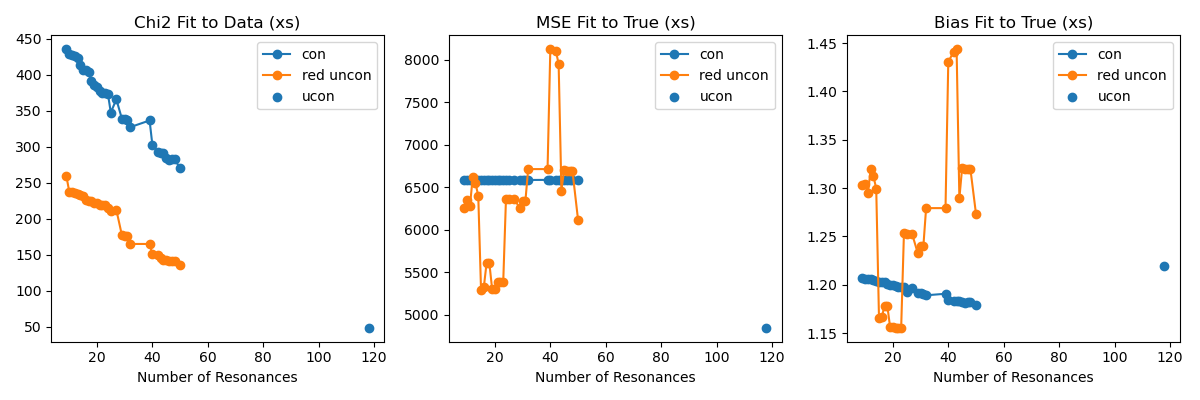

In [ ]:
# figure()
# plot(target_numres, chi2_con, '-o', label='constrained')
# plot(target_numres, chi2, '-o',label='reduced unconstrained')
# plot(target_numres, MSE_con, '-o', label='constrained')
# plot(target_numres, MSE, '-o',label='reduced unconstrained')
# plot(target_numres, abs(np.array(mean_bias_con)), '-o', label='constrained')
# plot(target_numres, abs(np.array(mean_bias)), '-o',label='reduced unconstrained')
# legend()
target_numres_plot = target_numres[target_wcon!=0]

fig, axes = subplots(1,3, figsize=(12,4), sharex=True)

axes[0].plot(target_numres_plot, chi2_con, '-o', label='con')
axes[0].plot(target_numres_plot, chi2, '-o',label='red uncon')
axes[1].plot(target_numres_plot, MSE_con, '-o', label='con')
axes[1].plot(target_numres_plot, MSE, '-o',label='red uncon')

# axes[2].errorbar(target_numres, abs(np.array(mean_bias_con)), yerr =(std_bias_con), fmt='.', label='con')
# axes[2].errorbar(target_numres, abs(np.array(mean_bias)), yerr =(std_bias), fmt='.', label='red uncon')
axes[2].plot(target_numres_plot, np.array(mean_bias_con), '-o', label='con')
axes[2].plot(target_numres_plot, np.array(mean_bias), '-o',label='red uncon')

axes[0].scatter(max_numres, chi2ucon, marker='o', label='ucon')
axes[1].scatter(max_numres, MSEucon, marker='o', label='ucon')
axes[2].scatter(max_numres, np.mean(bias_ucon), marker='o', label='ucon')

for ax in axes:
    ax.legend()
    ax.set_xlabel('Number of Resonances')

axes[0].set_title('Chi2 Fit to Data (xs)')
axes[1].set_title('MSE Fit to True (xs)')
axes[2].set_title('Bias Fit to True (xs)')

fig.tight_layout()

/Users/noahwalton/opt/anaconda3/envs/atari/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:502: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super().__init__(**kwargs)


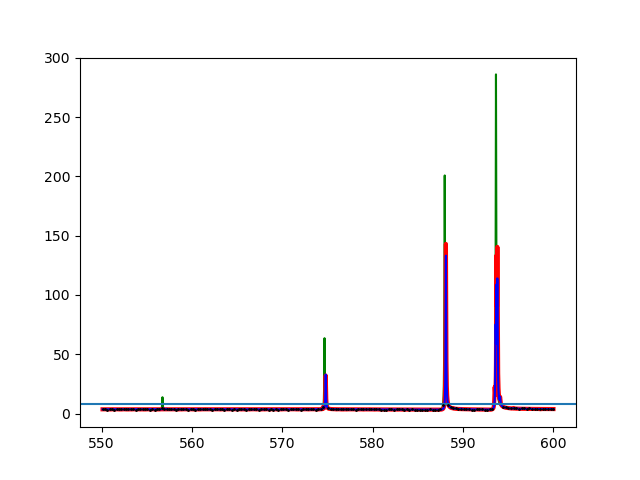

In [ ]:
figure()

errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(dc.pw_exp.E, reduced_feature_matrix@unconstrained_solw_reduced+potential_scattering.flatten(), color='blue')
# plot(dc.pw_exp.E, Resonance_Matrix@unconstrained_w+potential_scattering.flatten(), color='purple')

# plot(dc.pw_exp.E, test, 'g')
plot(dc.pw_fine.E, dc.pw_fine.theo_xs, 'g')
# plot(dc.pw_fine.E, dc.pw_fine[f'est_{2}_xs'], 'bo') #-dc.pw_fine[f'est_{15}_xs'])
plot(dc.pw_fine.E, dc.pw_fine[f'est_{13}_xs'], 'r', lw=3)
plot(dc.pw_fine.E, dc.pw_fine[f'est_{23}_xs'], 'b')

axhline(max_xs)

In [ ]:
### fine grid weight versus constraint
# x_constrained = []

# for fac in np.linspace(0,0.6,200):
#     G_wc = np.vstack([G,np.ones(len(unconstrained_w))])
#     h_wc = np.append(h, unconstrained_weight*fac)
#     res = solve_qp(P, q, G=G_wc, h=h_wc, A=None, b=None, lb=lb, ub=ub, 
#                                                         solver="cvxopt",
#                                                         verbose=False,
#                                                         abstol=1e-10,
#                                                         reltol=1e-10,
#                                                         feastol= 1e-8,
#                                                         maxiters = 500)
#     x_constrained.append(res)

# x_constrained = np.load('ws_vs_wconstraint.npy')
# x_nonzero = []
# for each in x_constrained:
#     try:
#         non0 = np.count_nonzero(each>w_threshold)
#     except:
#         non0 = np.nan
#     x_nonzero.append(non0)

# figure()
# plot(np.linspace(0,0.6,200), x_nonzero, '.')

In [ ]:
# est_resladder = fn.get_resonance_ladder_from_feature_bank(constrained_res, Elam_features, Gtot_features, w_threshold)
# dc.add_estimate(est_resladder)

# figure()

# errorbar(dc.pw_exp.E, dc.pw_exp.exp_xs, yerr=np.sqrt(np.diag(dc.CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# # plot(dc.pw_exp.E, Resonance_Matrix@lp_res.x+potential_scattering.flatten(), lw=2, color='purple')
# # plot(dc.pw_exp.E, Resonance_Matrix@constrained_res+potential_scattering.flatten(), color='blue')
# plot(dc.pw_fine.E, dc.pw_fine.theo_xs, 'g')
# plot(dc.pw_fine.E, dc.pw_fine.est_xs, 'b')

# scatter(np.array(dc.pw_exp.E)[index_0T], np.ones(len(index_0T))* max_xs)
# ylim([-5, max_xs*1.5])